# EXTRACTOR Nº 5: AUTOENCODER

Un autoencoder es un tipo de red neuronal diseñada para aprender representaciones compactas de los datos de entrada, generalmente con el objetivo de reducir la dimensionalidad o para eliminar ruido. Es un modelo de aprendizaje no supervisado y se utiliza principalmente para codificar (comprimir) y decodificar datos, con la intención de que la salida reconstruida sea lo más parecida posible a la entrada original.

En este caso, el autoencoder nos sirve como una herramienta para generar representaciones compactas y significativas (embeddings) de las imágenes que capturan sus características visuales más relevantes. El codificador del autoencoder toma como entrada una imagen y la transforma en un vector latente de menor dimensionalidad. Este vector contiene una representación compacta de las características visuales importantes, como formas, colores y texturas. Aunque el decodificador está presente para garantizar que el espacio latente preserve suficiente información para reconstruir la imagen original, en CBIR, el decodificador no se usa directamente durante la búsqueda. Solo utilizaremos el codificador para extraer las carcaterísticas.

Una vez que todas las imágenes la una base de datos se han pasado por el codificador, los vectores latentes generados se almacenan en un índice (FAISS) que permite realizar búsquedas rápidas por similitud.

<div style="text-align: center;">
    <img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/convolutional-autoencoder.png" width="600" height="200">
</div>


Las importaciones necesarias para generar este extractor son las siguientes:

In [1]:
# Manejo de las imagenes
from pathlib import Path
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import Input
from tensorflow.keras.preprocessing import image as imageprep

# Scikit-learn
from sklearn.preprocessing import normalize

# FAISS (para búsqueda de vectores)
import faiss

Comenzaremos abriendo y preprocesando los valores de las imágenes de entrenamiento: 

In [2]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Redimensionar la imagen al tamaño objetivo
    img = img.resize(target_size)
    # Convertir la imagen en un array de numpy y normalizar (escalar píxeles a 0-1)
    img_array = np.array(img) / 255.0
    return img_array

# Ruta principal donde está almacenado el dataset
dataset_path = Path("./DatasetArteTrainTest/Train")

# Creamos el DataFrame vacío
df = pd.DataFrame()

# Obtenemos todas las imágenes en cada subcarpeta
df['image'] = [str(file) for file in dataset_path.rglob('*.jpg') if file.is_file()]
df['Preprocessed_Images'] = df['image'].apply(preprocess_image)

# Verificamos las primeras filas para asegurarnos de que las rutas están correctas y que están todas las imagenes. 
print(df['image'].shape[0], ' imagenes en total.') 
df.head()

324  imagenes en total.


,image,Preprocessed_Images
0,DatasetArteTrainTest\Train\185139-Rococo.jpg,"[[[0.30196078431372547, 0.24705882352941178, 0..."
1,DatasetArteTrainTest\Train\185140-Rococo.jpg,"[[[0.2901960784313726, 0.23137254901960785, 0...."
2,DatasetArteTrainTest\Train\185141-Rococo.jpg,"[[[0.35294117647058826, 0.25882352941176473, 0..."
3,DatasetArteTrainTest\Train\185142-Rococo.jpg,"[[[0.4196078431372549, 0.35294117647058826, 0...."
4,DatasetArteTrainTest\Train\185143-Rococo.jpg,"[[[0.2901960784313726, 0.2235294117647059, 0.1..."


In [3]:
img_train = np.array(df['Preprocessed_Images'].tolist())

Una vez tenemos los valores preprocesados, comenzaremos definiendo la estructura del autoencoder:

La arquitectura consta de dos partes principales:
- El encoder se encarga de reducir las dimensiones de la imagen de entrada a través de varias capas convolucionales con activación ReLU, cada una con un stride de 2, lo que reduce progresivamente el tamaño espacial de la imagen mientras extrae características más abstractas. 
- El decoder, por su parte, toma la representación comprimida del encoder y aumenta las dimensiones espaciales mediante capas de upsampling, utilizando convoluciones para reconstruir la imagen original. 

El autoencoder se entrena para minimizar la pérdida entre la imagen original y la reconstruida, aprendiendo así representaciones compactas y significativas para las imágenes.

In [4]:
def create_autoencoder(input_shape):

    input_form = Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, activation="relu", strides=2, padding='same', name='enc_conv1')(input_form)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", strides=2, padding='same', name='enc_conv2')(x)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", strides=2, padding='same', name='enc_conv3')(x)
    x = layers.Conv2D(128, kernel_size=3, activation="relu", strides=2, padding='same', name='enc_conv4')(x)

    x = layers.Conv2D(128, kernel_size=3, activation="relu", padding='same', name='dec_conv0')(x)
    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling1')(x)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding='same', name='dec_conv2')(x)
    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling2')(x)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding='same', name='dec_conv3')(x)
    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling3')(x)
    x = layers.Conv2D(32, kernel_size=3, activation="relu", padding='same', name='dec_conv4')(x)
    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling4')(x)
    x = layers.Conv2D(3, kernel_size=3, activation="sigmoid", padding='same', name='dec_conv5')(x)

    optimizer = Adam()
    autoencoder = Model(input_form, x)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

    return autoencoder

input_size = (224, 224, 3)
autoencoder = create_autoencoder(input_size)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv3 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv4 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv0 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsampling1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2D)              │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsampling2 (UpSampling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv3 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsampling3 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv4 (Conv2D)              │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsampling4 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv5 (Conv2D)              │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,811 (1.56 MB)

 Trainable params: 407,811 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Una vez creado el modelo, si ya existe el fichero con el autoencoder entrenado, solo hace falta cargarlo y cargar la capa convolucional correspondiente con el encoder. Si no, hace falta entrenarlo desde 0 y guardarlo en el fichero. 

In [5]:
filename = 'autoencoder.keras'
condition = False

if not os.path.exists(filename):
    autoencoder.fit(img_train, img_train,
            epochs=50,
            batch_size=32)
    autoencoder.save(filename)
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dec_conv0').output)
else:
    autoencoder = keras.models.load_model(filename)
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dec_conv0').output)

Ahora, creamos una función para extraer las características de las imágenes de entrenamiento. Como vamos a utilizar Flat Index nos conviene normalizarlas antes de crear el índice.

In [6]:
def autoencoder_features(images: np.array):
    features = encoder.predict(images)
    # Lo convertimos en biidimensional.
    features = features.reshape(features.shape[0], -1)
    # Normalizamos
    features = normalize(features, norm='l2')
    features = features.astype('float32')
    faiss.normalize_L2(features)
    return features

Creamos el índice solo si el fichero no existía ya:

In [7]:
filename = 'database/feat_extract_5.index'
if not os.path.exists(filename):
    train_features= autoencoder_features(img_train)
    index = faiss.IndexFlatL2(train_features.shape[1])  # L2 distance
    index.add(train_features)  # Añadir las características al índice
    # Guardar el índice en el archivo correspondiente
    faiss.write_index(index, filename)
else:
    index = faiss.read_index(filename)

Ahora que tenemos el índice, procedemos a probar con una imagen de consulta:

In [8]:
def autoencoder_extractor(image: np.array, encoder):
    # batch dimension
    image = np.expand_dims(image, axis=0)
    feature_vector = encoder.predict(image)
    feature_vector = feature_vector.reshape(1, -1)
    return feature_vector

test_dir = "./DatasetArteTrainTest/Test/"
query_index = 25
query_image = os.path.join(test_dir, os.listdir(test_dir)[query_index])
query_image = preprocess_image(query_image)
k = 9

# Extraer caracteristicas de la imagen query
feature_vector = autoencoder_extractor(query_image, encoder)
# Buscar en el indice los k vectores más parecidos
_, indices = index.search(feature_vector, k)
# Extraer las imágenes asociadas
nearest_images = [img_train[idx] for idx in indices[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Mostramos los resultados:

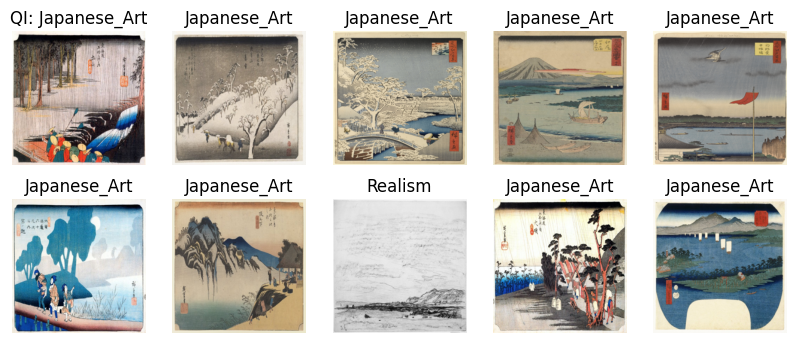

In [9]:
def show_result(similar_images, query_image):
    k = len(similar_images)

    # Crear una figura y subgráficas (subplots)
    fig, axes = plt.subplots(2, int((k + 1)/2), figsize=(10, 4))

    axes = axes.flatten()

    # Plotear la imagen de consulta
    axes[0].imshow(query_image)
    axes[0].set_title("QI: " + os.listdir(test_dir)[query_index].split('-')[1].split('.')[0])
    axes[0].axis('off')

    # Plotear las imágenes más similares
    for i, sim_img in enumerate(similar_images):
        axes[i + 1].imshow(sim_img)
        img_name = Path(df['image'][indices[0][i]]).name.split('-')[1].split('.')[0]  
        axes[i + 1].set_title(img_name)
        axes[i + 1].axis('off')

    plt.show()

show_result(nearest_images, query_image)